In [1]:
import cv2
import numpy as np


class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targeted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(
                    self.save_activation))
            # Backward compatibility with older pytorch versions:
            if hasattr(target_layer, 'register_full_backward_hook'):
                self.handles.append(
                    target_layer.register_full_backward_hook(
                        self.save_gradient))
            else:
                self.handles.append(
                    target_layer.register_backward_hook(
                        self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu().detach()] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


class GradCAM:
    def __init__(self,
                 model,
                 target_layers,
                 reshape_transform=None,
                 use_cuda=False):
        self.model = model.eval()
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    @staticmethod
    def get_cam_weights(grads):
        return np.mean(grads, axis=(2, 3), keepdims=True)

    @staticmethod
    def get_loss(output, target_category):
        loss = 0
        for i in range(len(target_category)):
            loss = loss + output[i, target_category[i]]
        return loss

    def get_cam_image(self, activations, grads):
        weights = self.get_cam_weights(grads)
        weighted_activations = weights * activations
        cam = weighted_activations.sum(axis=1)

        return cam

    @staticmethod
    def get_target_width_height(input_tensor):
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(self, input_tensor):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer

        for layer_activations, layer_grads in zip(activations_list, grads_list):
            cam = self.get_cam_image(layer_activations, layer_grads)
            cam[cam < 0] = 0  # works like mute the min-max scale in the function of scale_cam_image
            scaled = self.scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer):
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return self.scale_cam_image(result)
        # return result

    @staticmethod
    def scale_cam_image(cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img)
            img = img / (1e-7 + np.max(img))
            if target_size is not None:
                img = cv2.resize(img, target_size)
            result.append(img)
        result = np.float32(result)

        return result

    def __call__(self, input_tensor, target_category=None):

        if self.cuda:
            input_tensor = input_tensor.cuda()

        # 正向传播得到网络输出logits(未经过softmax)
        output = self.activations_and_grads(input_tensor)
        output=output.view(16,2)
        # return output
        if isinstance(target_category, int):
            target_category = [target_category] * 16

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy(), axis=-1)
            print(f"category id: {target_category}")
        else:
            assert (len(target_category) == 16)

        self.model.zero_grad()
        # return output, target_category
        loss = self.get_loss(output, target_category)
        loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor)
        # print(cam_per_layer.shape)
        return self.aggregate_multi_layers(cam_per_layer)
        # return cam_per_layer
    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True


def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def center_crop_img(img: np.ndarray, size: int):
    h, w, c = img.shape

    if w == h == size:
        return img

    if w < h:
        ratio = size / w
        new_w = size
        new_h = int(h * ratio)
    else:
        ratio = size / h
        new_h = size
        new_w = int(w * ratio)

    img = cv2.resize(img, dsize=(new_w, new_h))

    if new_w == size:
        h = (new_h - size) // 2
        img = img[h: h+size]
    else:
        w = (new_w - size) // 2
        img = img[:, w-int(size/2): w+int(size/2)]

    return img
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
# from utils import GradCAM, show_cam_on_image


# def main():
# model = models.mobilenet_v2(pretrained=True)
# target_layers = [model.features[-1]]

# model = models.vgg16(pretrained=True)
# target_layers = [model.features]

# model = models.resnet34(pretrained=True)
# target_layers = [model.layer4]

# # model = models.regnet_y_800mf(pretrained=True)
# # target_layers = [model.trunk_output]

# # model = models.efficientnet_b0(pretrained=True)
# # target_layers = [model.features]

# data_transform = transforms.Compose([transforms.ToTensor(),
#                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# # load image
# img_path = "/home/hk/python_script/Ukraine/data/img/both.png"
# assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
# img = Image.open(img_path).convert('RGB')
# img = np.array(img, dtype=np.uint8)

# # [N, C, H, W]
# img_tensor = data_transform(img)
# # expand batch dimension
# input_tensor = torch.unsqueeze(img_tensor, dim=0)

# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
# target_category = 281  # tabby, tabby cat
# # target_category = 254  # pug, pug-dog

# grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
#                                     grayscale_cam,
#                                     use_rgb=True)
# plt.imshow(visualization)
# plt.show()


# if __name__ == '__main__':
#     main()


In [60]:

class GradCAM_bb:
    def __init__(self,
                 model,
                 target_layers,
                 reshape_transform=None,
                 use_cuda=False):
        self.model = model.eval()
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    @staticmethod
    def get_cam_weights(grads):
        return np.mean(grads, axis=(2, 3), keepdims=True)

    @staticmethod
    def get_loss(output, target_category):
        loss = 0
        for i in range(len(target_category)):
            loss = loss + output[i, target_category[i]]
        return loss

    def get_cam_image(self, activations, grads):
        weights = self.get_cam_weights(grads)
        weighted_activations = weights * activations
        cam = weighted_activations.sum(axis=1)

        return cam

    @staticmethod
    def get_target_width_height(input_tensor):
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(self, input_tensor):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer

        for layer_activations, layer_grads in zip(activations_list, grads_list):
            cam = self.get_cam_image(layer_activations, layer_grads)
            cam[cam < 0] = 0  # works like mute the min-max scale in the function of scale_cam_image
            scaled = self.scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer):
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return self.scale_cam_image(result)

    @staticmethod
    def scale_cam_image(cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img)
            img = img / (1e-7 + np.max(img))
            if target_size is not None:
                img = cv2.resize(img, target_size)
            result.append(img)
        result = np.float32(result)

        return result

    def __call__(self, input_tensor, target_category=None):

        if self.cuda:
            input_tensor = input_tensor.cuda()

        # 正向传播得到网络输出logits(未经过softmax)
        output = self.activations_and_grads(input_tensor)
        if isinstance(target_category, int):
            target_category = [target_category] * input_tensor.size(0)

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy(), axis=-1)
            print(f"category id: {target_category}")
        else:
            assert (len(target_category) == input_tensor.size(0))

        self.model.zero_grad()
        loss = self.get_loss(output, target_category)
        loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor)

        return self.aggregate_multi_layers(cam_per_layer)
        # return cam_per_layer
    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True


In [44]:
import sys
import imageio
import matplotlib.pyplot as plt
import torch
import numpy as np
sys.path.append('..')
from model import mynet6size120mtc1v7
from model import mynet6size120
from model import resnet50
# model=mynet6size120mtc1v7.mynet6size120mtc1v7()
from collections import OrderedDict
# hhh=torch.load('/ssd/hk/Syria_samples/split_havedamaged_size120_all_v3/train2.pth')
# w=torch.load('/home/hk/python_script/Ukraine/checkpoints/试一试_mynet6size120mtc1v2_Ukrain_size120_allcitiesall_effectweight_v3_multi-time_RandomDelandCopyv2_2/best_ckpt.pt')['model_state_dict']

# model2.load_state_dict(w2)

In [197]:
def cat(img_pre,img_post):
    data=np.concatenate((img_pre,img_post),axis=0)
    data=torch.Tensor(data)
    return data
def show_mt_cam(mt,t,tl):
# mt=643
    # t=tl=0
    # w=torch.load('/home/hk/python_script/Ukraine/checkpoints/试一试_mynet6size120mtc1v7_Syria_size120_allcitiesall_effectweight_v3_multi-time_RandomDelandCopyv2_6/best_ckpt.pt')['model_state_dict']
    w=torch.load('/home/hk/python_script/Ukraine/checkpoints/试一试_mynet6size120mtc1v7_Syria_size120_allcitiesall_effectweight_v3_multi-time_RandomDelandCopyv2_6/best_ckpt.pt')['model_state_dict']
    w2={}
    for k in w.keys():

        k2=k.replace('module.','')
        w2[k2]=w[k]
    w2=OrderedDict(w2)
    model=mynet6size120mtc1v7.mynet6size120mtc1v7()
    model.load_state_dict(w2)
    pathes=hhh[mt][0]
    label=hhh[mt][1]
    path_pre=pathes[0]
    path_post=pathes[1:]

    labels=label[1:]
    img_pre=imageio.imread(path_pre).transpose(2,0,1)
    imgs=[cat(img_pre,imageio.imread(post).transpose(2,0,1)) if post is not None else np.zeros((6,120,120)) for post in path_post]
    data=np.concatenate(imgs,axis=0)

    labels_v=[]
    for label in labels:
        if label=='p':
            labels_v.append(1)
        elif label=='n':
            labels_v.append(0)
        elif label is None:
            labels_v.append(-1)
        else:
            print(label)
            print(path_pre)
            print('label error')
    if np.array(labels_v).sum()==-16:
        # print(labels_)
        print(labels)
        # print(mask_num,mask)
    labels_v=torch.tensor(labels_v)
    input=[data,labels_v]
    input[0]=torch.Tensor(input[0])
    output=model(torch.Tensor(input[0]).unsqueeze(0))
    # print('feature1 shape:',feature1.shape)
    # print('feature2 shape:',feature2.shape)
    ll=input[1].cpu().numpy()
    pp=torch.argmax(output,dim=2)[0].cpu().numpy()
    print('label      :',input[1].cpu().numpy())
    print('pred result:',torch.argmax(output,dim=2)[0].cpu().numpy())
    for i in range(len(ll)):
        if ll[i]==-1:
            continue
        elif ll[i]!=pp[i]:
            raise()
    if tl==0:
        target_layers=[model.encoder.fn]
    elif tl==1:
        target_layers=[model.encoder.se]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    target_category = t # tabby, tabby cat
    # target_category = 254  # pug, pug-dog
    grayscale_cam = cam(input_tensor=torch.unsqueeze(torch.Tensor(input[0]), dim=0), target_category=target_category)
    # for i in range(16):



    city=os.path.basename(hhh[mt][0][0]).split('_')[0]
    coord=hhh[mt][0][0].split('_')[-1][:6]
    print('A')
    pre=imageio.imread(hhh[mt][0][0])


    n=1

    len_p=len([i for i in hhh[mt][0] if i is not None])
    for index in range(len_p-4,len_p):
        # print(index)

        if n==1 and mt==392:
            index=index-1
        # if n==3 and mt==392:
        #     index=index+1
        i=hhh[mt][0][index]
        if i is None:
            continue

        # print(i)
        l=os.path.basename(i).split('_')[1]

        m=imageio.imread(i)
        if 'enhance' in l:
            l=l[8:]
        # print(l,f'label:{input[1].cpu().numpy()[index-1]}',f'pred:{torch.argmax(output,dim=2)[0].cpu().numpy()[index-1]}')
        if 'rebuilding' not in i:
            label=hhh[mt][1][index]
            # print(label)
        else:
            label='r'
            # print(label)
        # if l[0] in ['B','C','D','E','F']:
        #     mask=np.load('/ssd/hk/Syria_samples/samples_rebuilding/label/'+f'{city}_{l[0]}_{coord}.npy')
        #     d_coords=np.array(np.where(mask>0))
        #     for i in range(d_coords.shape[1]):
        #         d_coord=d_coords[:,i]
        #         if label=='p':
        #             m[d_coord[0]-5:d_coord[0]+5,d_coord[1],:]=0
        #             m[d_coord[0],d_coord[1]-5:d_coord[1]+5,:]=0
        #             m[d_coord[0]-5:d_coord[0]+5,d_coord[1],0]=255
        #             m[d_coord[0],d_coord[1]-5:d_coord[1]+5,0]=255
        #         elif label=='n':
        #             m[d_coord[0]-5:d_coord[0]+5,d_coord[1],:]=255
        #             m[d_coord[0],d_coord[1]-5:d_coord[1]+5,:]=255
        # elif l[0]=='A':
        #     pass
        # else:
        #     for i in range(d_coords.shape[1]):
        #         d_coord=d_coords[:,i]
        #         m[d_coord[0]-5:d_coord[0]+5,d_coord[1],:]=255
        #         m[d_coord[0],d_coord[1]-5:d_coord[1]+5,:]=255
        #         m[d_coord[0]-5:d_coord[0]+5,d_coord[1],2]=0
        #         m[d_coord[0],d_coord[1]-5:d_coord[1]+5,2]=0




        # w_resnet=torch.load('/home/hk/python_script/Ukraine/checkpoints/试一试_resnet50_Syria_size120_allcitiesall_effectweight_v2/best_ckpt.pt')['model_state_dict']
        # w2_resnet={}
        # for k in w_resnet.keys():

        #     k2=k.replace('module.','')
        #     w2_resnet[k2]=w_resnet[k]
        # w2_resnet=OrderedDict(w2_resnet)
        # model_resnet50=resnet50.resnet50()
        # model_resnet50.load_state_dict(w2_resnet)


        # ttensor=transforms.Compose([transforms.ToTensor()])
        # path_pre=pathes[0]
        # path_post=pathes[index]
        # img_pre,img_post=imageio.imread(path_pre),imageio.imread(path_post)
        # img_pre,img_post=ttensor(img_pre.copy()),ttensor(img_post.copy())
        # data_tt=np.concatenate((img_pre,img_post),axis=0)



        # # print(torch.argmax(output_resnet50,dim=1)[0].cpu().numpy())

        # target_layers_resnet50=[model_resnet50.stack4[-1]]
        # cam_resnet50 = GradCAM_bb(model=model_resnet50, target_layers=target_layers_resnet50, use_cuda=False)
        # target_category_resnet50 = t # tabby, tabby cat
        # # target_category = 254  # pug, pug-dog
        # grayscale_cam_resnet50 = cam_resnet50(input_tensor=torch.unsqueeze(torch.Tensor(data_tt.copy()), dim=0), target_category=target_category)
        # grayscale_cam_resnet50=grayscale_cam_resnet50[0, :]
        # visualization_resnet50 = show_cam_on_image(m / 255.,
        #                                 grayscale_cam_resnet50,
        #                                 use_rgb=True)

        # output_resnet50=model_resnet50(torch.unsqueeze(torch.Tensor(data_tt.copy()), dim=0))
        # print(torch.argmax(output_resnet50,dim=1)[0].cpu().numpy())

        # print(pathes[index])




        grayscale_cam_i = grayscale_cam[index-1, :]
        visualization = show_cam_on_image(m / 255.,
                                            grayscale_cam_i,
                                            use_rgb=True)
        fig = plt.figure(figsize=(30,10),dpi=400)
        # plt.figure(figsize=(10,10))
        # plt.imshow(mask)
        # plt.show()
        ax = fig.add_subplot(1,3,1)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(pre)
        # n+=1
        
        # ax = fig.add_subplot(4,5,n)
        # ax.set_yticks([])
        # ax.set_xticks([])
        # ax.imshow(np.ones((120,120,3))*255)
        # n+=1
        
        # ax = fig.add_subplot(4,5,n)
        # ax.set_yticks([])
        # ax.set_xticks([])
        # ax.imshow(np.ones((120,120,3))*255)
        # n+=1

        ax = fig.add_subplot(1,3,2)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(m)
        # n+=1
        
        # print(n)
        ax = fig.add_subplot(1,3,3)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(visualization)
        # n+=1

        # ax = fig.add_subplot(2,9,n)
        # ax.imshow(visualization_resnet50)
        # n+=1
        # ax = fig.add_subplot(1,3,3)
        # ax.imshow(feature2[index-1,0,:,:])
        fig.savefig(f'/home/hk/python_script/Ukraine/fig/PtNet-MTCF_{mt}-{n}_1.png')
        n+=1
    plt.show()

392
label      : [ 1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1]
pred result: [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
A


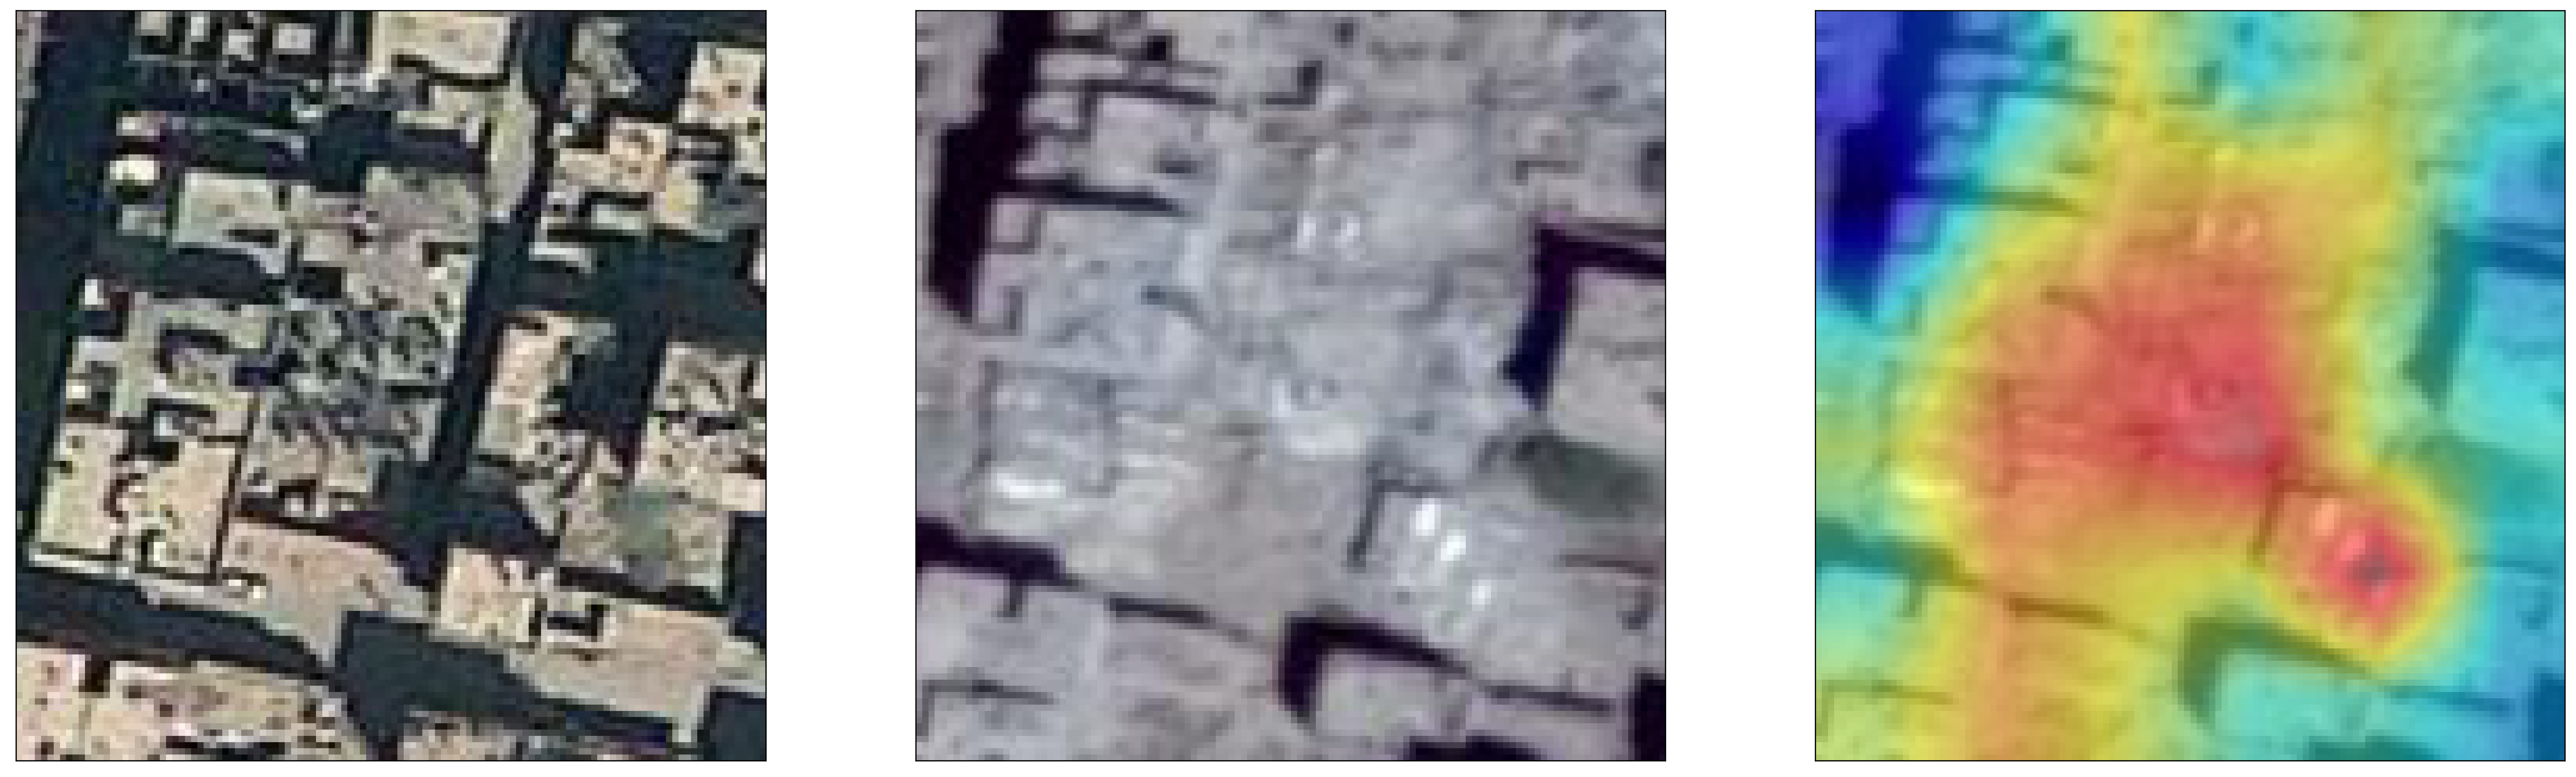

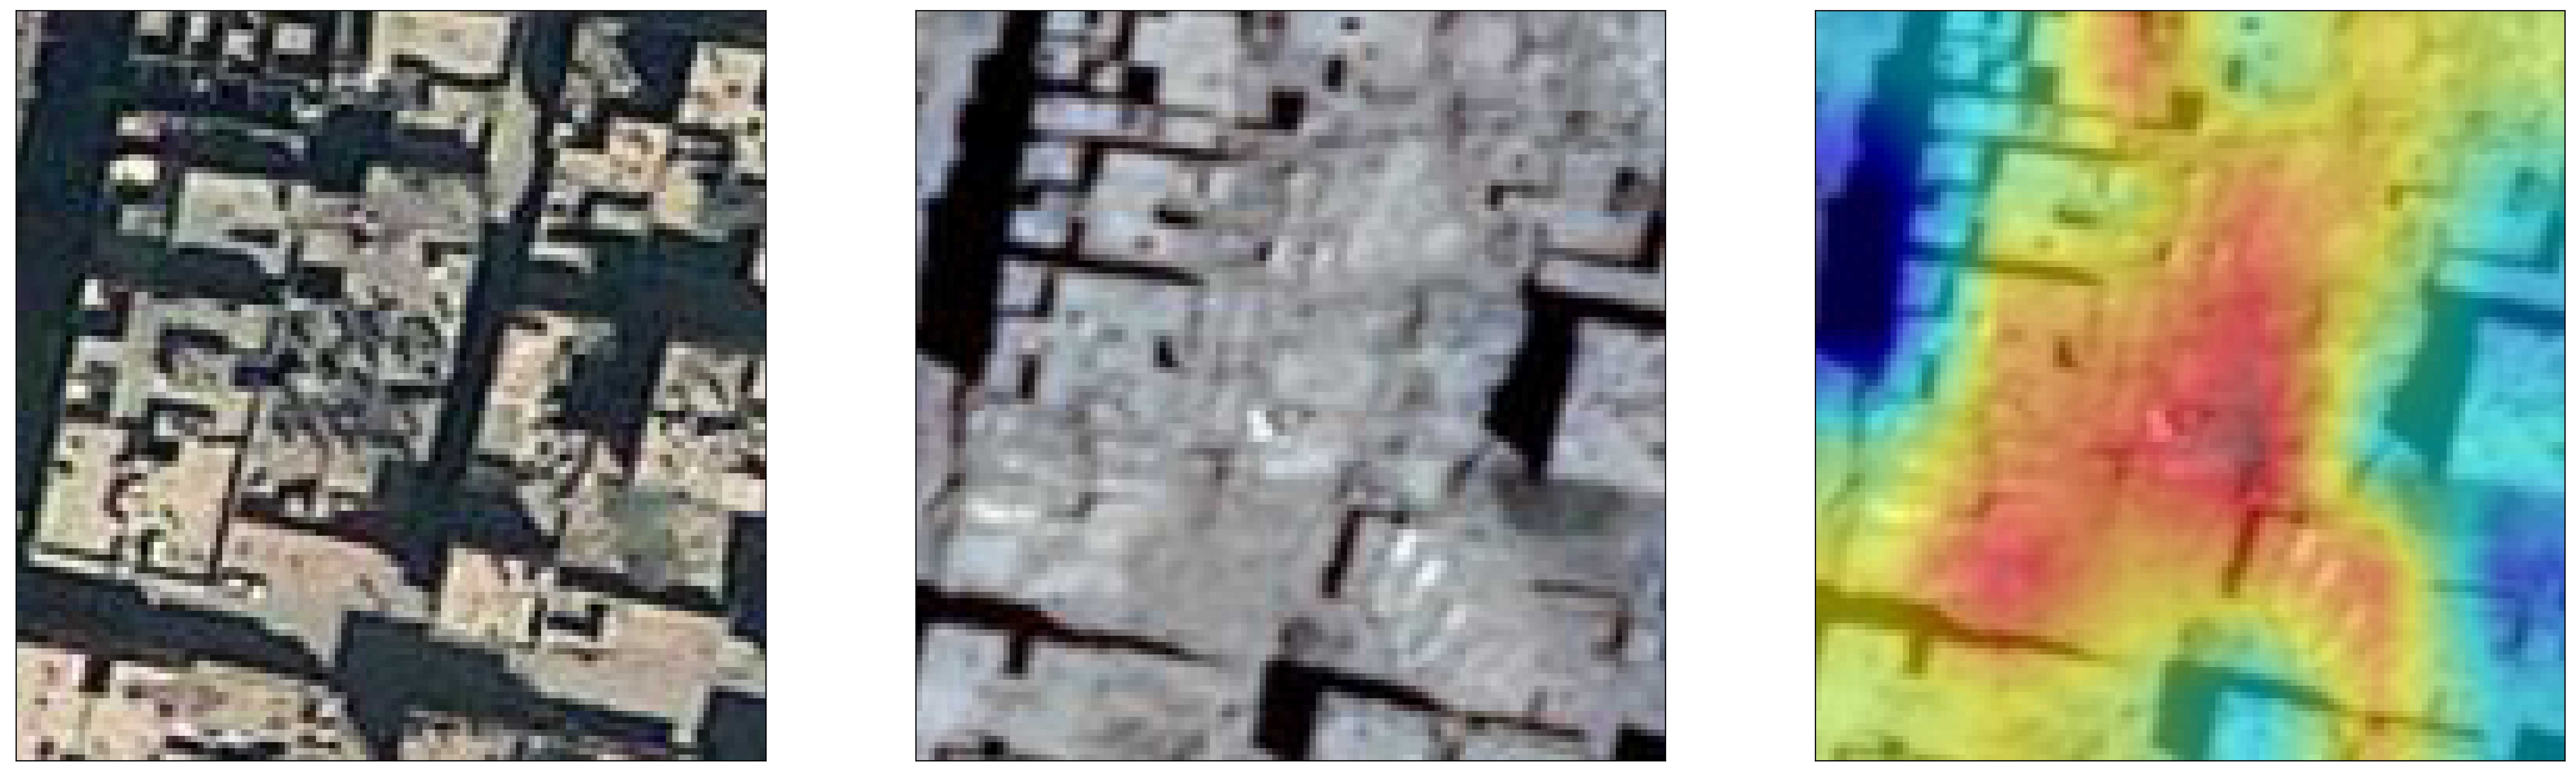

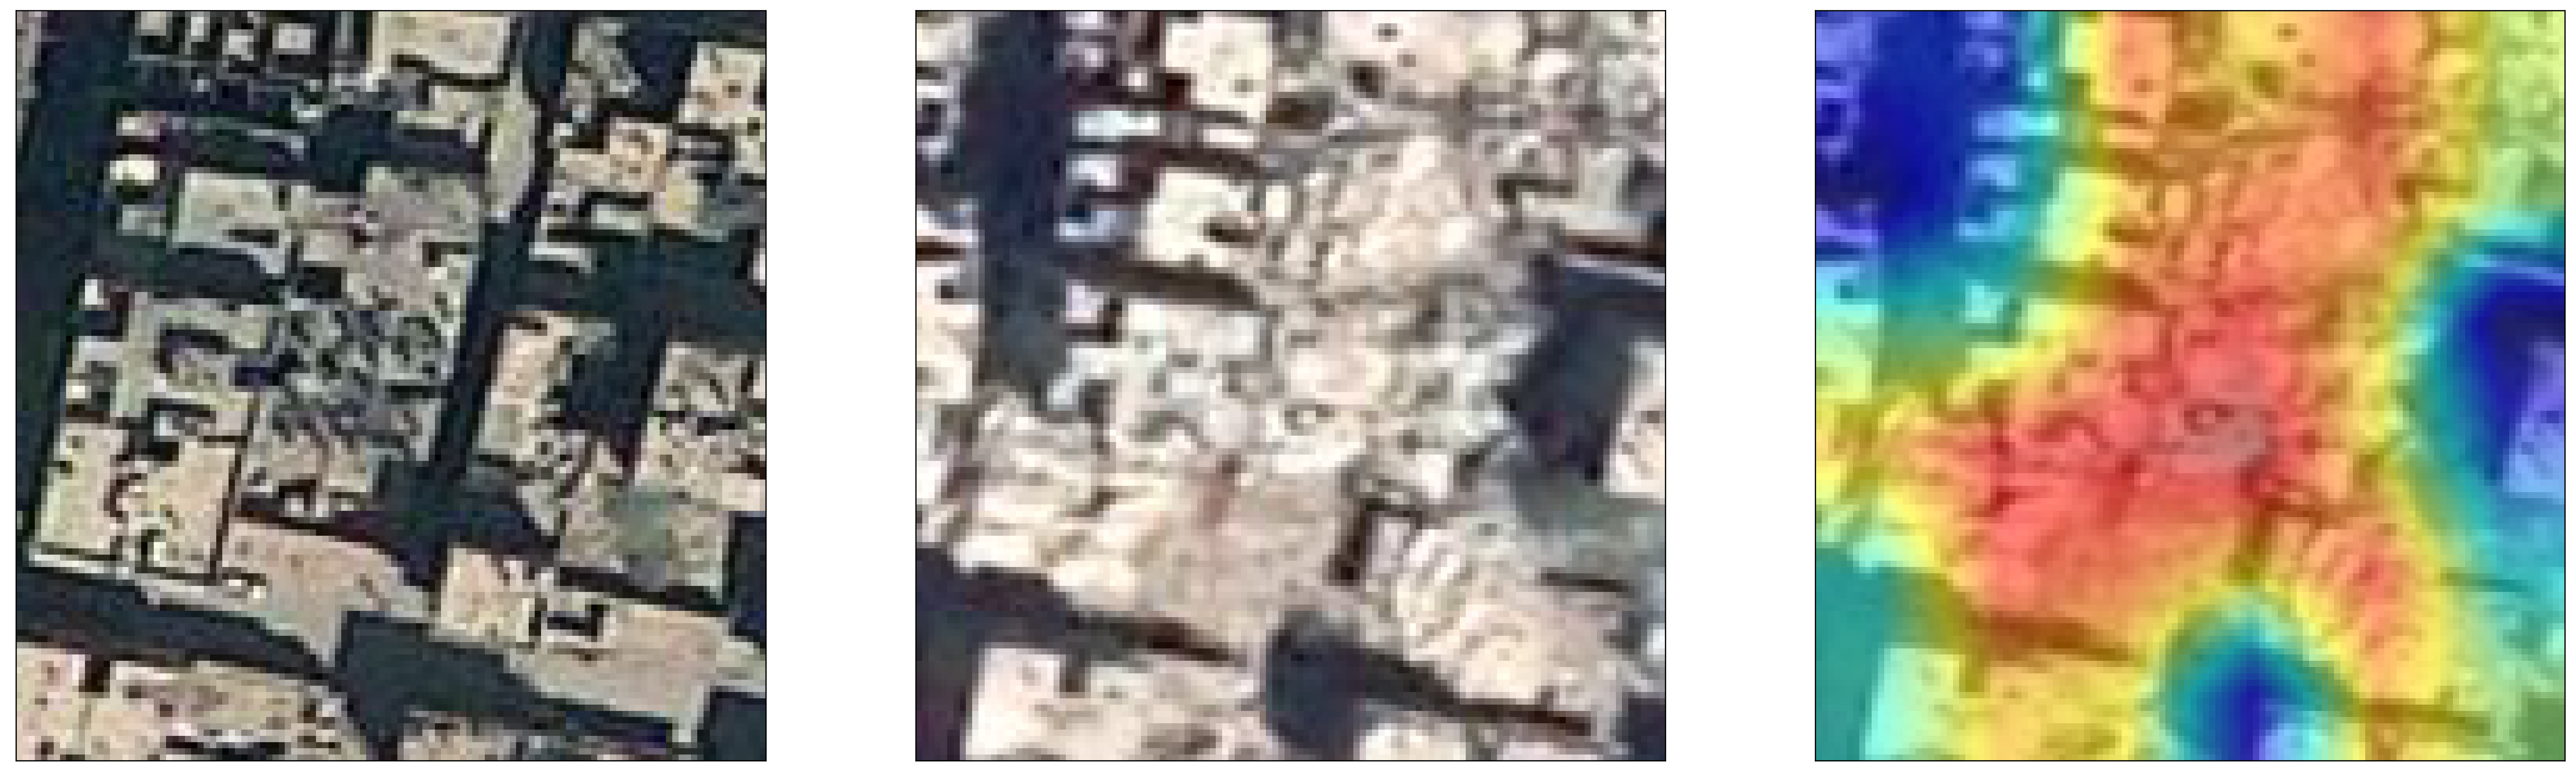

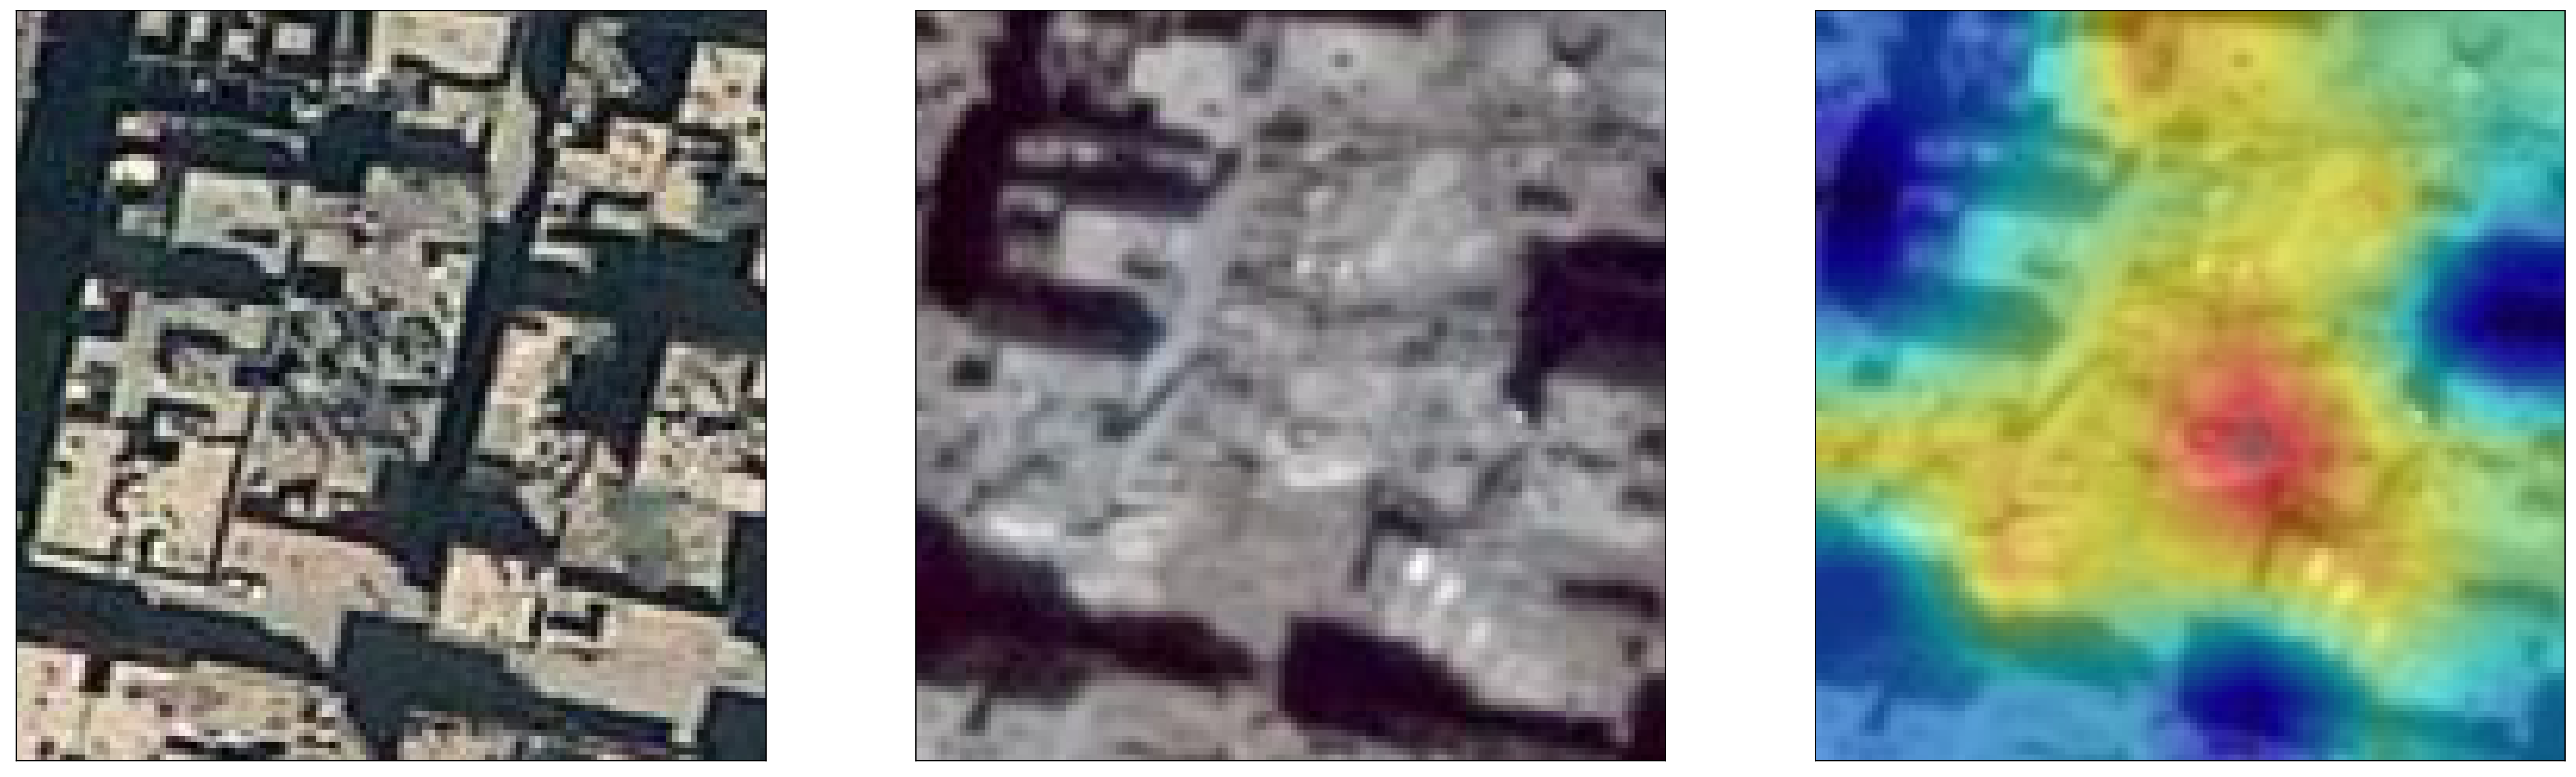

In [200]:

# mts=[975,1041,1042,1112]
# mts=[392,643,691,1112]
mts=[392]
for mt in mts:
    # try:
    print(mt)
    show_mt_cam(mt,0,0)
        # show_mt_cam(mt,1,0)
        # break
    # except:
    #     print('error',mt)


In [140]:
pathes_use=['/ssd/hk/Syria_samples/samples_enhance_v2/post/Deir-ez-Zor_enhance-D-E-1_046085.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Deir-ez-Zor_enhance-E-Z-1_046085.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Deir-ez-Zor_enhance-E-Z-2_046085.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Deir-ez-Zor_enhance-E-Z-3_046085.png',
'/ssd/hk/Syria_samples/samples_v2/post/Aleppo_E_181241.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Aleppo_enhance-E-Z-1_181241.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Aleppo_enhance-E-Z-2_181241.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Aleppo_enhance-E-Z-3_181241.png',
'/ssd/hk/Syria_samples/samples_v2/post/Aleppo_E_028236.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Aleppo_enhance-E-Z-1_028236.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Aleppo_enhance-E-Z-2_028236.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Aleppo_enhance-E-Z-3_028236.png',
'/ssd/hk/Syria_samples/samples_v2/post/Homs_C_117114.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Homs_enhance-C-Z-1_117114.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Homs_enhance-C-Z-2_117114.png',
'/ssd/hk/Syria_samples/samples_enhance_v2/post/Homs_enhance-C-Z-3_117114.png']

In [146]:
pathes_use_save=[[i.replace('post','pre'),'p'] for i in pathes_use]
torch.save(pathes_use_save,'/ssd/hk/Syria_samples/split_havedamaged_size120_all_v2/CAM.pth')

In [142]:
torch.load('/ssd/hk/Syria_samples/split_havedamaged_size120_all_v2/train2.pth')

[['/ssd/hk/Syria_samples/samples_v2/pre/Aleppo_B_163192.png', 'n'],
 ['/ssd/hk/Syria_samples/samples_enhance_v2/pre/Hama_enhance-A-B-1_053038.png',
  'n'],
 ['/ssd/hk/Syria_samples/samples_v2/pre/Aleppo_B_097275.png', 'n'],
 ['/ssd/hk/Syria_samples/samples_enhance_v2/pre/Aleppo_enhance-C-D-1_052235.png',
  'n'],
 ['/ssd/hk/Syria_samples/samples_enhance_v2/pre/Aleppo_enhance-C-D-1_146193.png',
  'p'],
 ['/ssd/hk/Syria_samples/samples_v2/pre/Aleppo_B_170230.png', 'n'],
 ['/ssd/hk/Syria_samples/samples_v2/pre/Aleppo_D_158274.png', 'p'],
 ['/ssd/hk/Syria_samples/samples_enhance_v2/pre/Aleppo_enhance-C-D-3_152230.png',
  'p'],
 ['/ssd/hk/Syria_samples/samples_v2/pre/Aleppo_B_047199.png', 'n'],
 ['/ssd/hk/Syria_samples/samples_enhance_v2/pre/Idlib_enhance-C-D-2_006024.png',
  'n'],
 ['/ssd/hk/Syria_samples/samples_enhance_v2/pre/Raqqa_enhance-D-Z-4_021177.png',
  'p'],
 ['/ssd/hk/Syria_samples/samples_enhance_v2/pre/Deir-ez-Zor_enhance-D-E-1_030102.png',
  'p'],
 ['/ssd/hk/Syria_samples/samp